In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gudhi
from tqdm import tqdm
from numba import jit

In [4]:
def number_of_b0_b1(p):
    rips = gudhi.RipsComplex(points = p, max_edge_length = 1.5)
    s_tree = rips.create_simplex_tree(max_dimension = 2)
    diag = s_tree.persistence()
    b0, b1 = 0, 0
    for dg in diag:
        if(dg[1][1] > 1.42):
            if(dg[0] == 0):
                b0 += 1
            if(dg[0] == 1):
                b1 += 1
    return b0, b1

In [5]:
@jit(forceobj=True)
def image_to_point(X):
    points = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(X[i, j] != 255):
                a = np.array([i, j])
                points.append(a)
    points = np.array(points)
    return points

In [137]:
def local_merging_number(X, patches_x, patches_y, step_perc = 1, name = 'image'):
    x_b0, x_b1 = number_of_b0_b1(image_to_point(X))

    px_s = (int)(X.shape[0] / patches_x) 
    py_s = (int)(X.shape[1] / patches_y)
    while((X.shape[0] - patches_x * px_s) >= px_s):
      px_s += 1
    while((X.shape[1] - patches_y * py_s) >= py_s):
      py_s += 1
    print(f"{X.shape}, px_s = {px_s}, py_s = {py_s}")
    
    
    Y = np.zeros([X.shape[0], X.shape[1]]) + 255

    offset = 0
    
    lg = np.zeros([patches_x, patches_y])
    # olg = np.zeros([patches_x, patches_y])

    step_x = (int)(step_perc * px_s)
    step_y = (int)(step_perc *py_s)
    i, j = 0, 0
    pbar = tqdm(total = X.shape[0] - px_s)
    while(i <= (X.shape[0] - px_s)):
      while(j <= (X.shape[1] - py_s)):
            X1 = np.zeros([X.shape[0], X.shape[1]]) + 255
            X2 = np.zeros([X.shape[0], X.shape[1]]) + 255
            # print(f"({i + 1} : {i + px_s}), ({j + 1} : {j + py_s}), {offset}")
            X1[ (i + 1) : (i + step_x), (j + 1) : (j + py_s) ] = np.array(X[(i + 1) : (i + step_x), (j + 1) : (j + py_s)])
            x1_b0, x1_b1 = number_of_b0_b1(image_to_point(X1[(i + 1) : (i + step_x), (j + 1) : (j + py_s)]))
            
            X2 = np.array(X)
            X2[ i : (i + px_s - 1), j : (j + py_s - 1)] = 255
            x2_b0, x2_b1 = number_of_b0_b1(image_to_point(X2))

            
            if(x2_b0 > x_b0):
              n = (int) (i/px_s)
              m = (int) (j/py_s)
              lg[n, m] += abs(x2_b0 + x1_b0 - x1_b0)
            
            # cv2.imwrite(f"./images/croped/{name}_X1_{offset}.png", X1)
            # cv2.imwrite(f"./images/croped/{name}_X2_{offset}.png", X2)
            # cv2.imwrite(f"./images/{dir}/image_X1UX2_{offset}.png", X1_U_X2[:,:,offset])
            offset+=1
            j += step_y
      j = 0
      i += step_x
      pbar.update(step_x)
    pbar.close()
    return lg

In [169]:
img = cv2.imread('./images/simple_binary4.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img.shape

(200, 200)

In [170]:
img = cv2.resize(img, [(int)(img.shape[0]/2), (int)(img.shape[1]/2)])
img.shape

(100, 100)

In [171]:
ret,X = cv2.threshold(img,70,255,cv2.THRESH_BINARY)

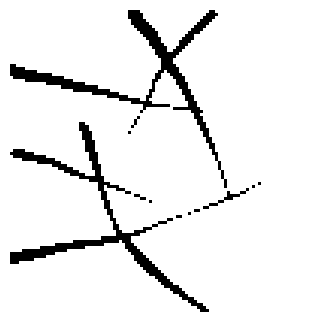

In [172]:
org_map = plt.cm.get_cmap('Greys')
rev_map = org_map.reversed()

fig1, ax1 = plt.subplots(dpi=100)
ax1.axis('off')
ax1.imshow(X, cmap=rev_map)
fig1.savefig('./images/LM/simple_binary4.png', dpi=200);

In [175]:
lg_num = local_merging_number(X, 30, 30, 0.5, 'lines')

(100, 100), px_s = 10, py_s = 10


95it [00:10,  8.96it/s]                        


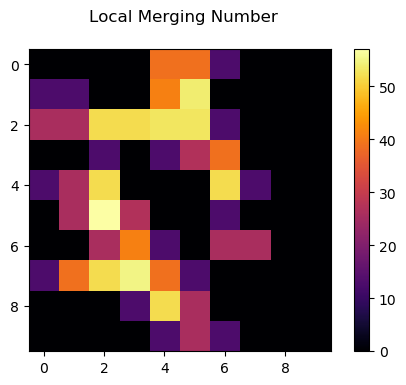

In [176]:
fig2, ax2 = plt.subplots(dpi=100)
fig2.suptitle("Local Merging Number")
im2 = ax2.imshow(lg_num, cmap='inferno')
fig2.colorbar(im2)
fig2.savefig('./images/LM/simple_binary4-lm.png', dpi=200);